# EEC55C30 Lab2
## (c) Deutsch's algorithm

### Enviroment setup

In [2]:
# qiskit tools
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit_ibm_runtime import Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_vector
# general tools
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService

### Paras

In [3]:
nshots = 1000
np.random.seed(1)  

## C.1 Problem
### Deutsch's algorithm solves the parity problem for the special case that n = 1. In the context of quantum computing this problem is sometimes referred to as Deutsch's problem, and we'll follow that nomenclature in this lesson.

Input: a function `f: {0, 1} → {0, 1}`

Output:
- `0` if `f` is constant  
- `1` if `f` is balanced





## C2. Implementation in Qiskit

In [4]:
def deutsch_function(case: int):
    # This function generates a quantum circuit for one of the 4 functions
    # from one bit to one bit
 
    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")
 
    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f

### Define the function f we want to guess

Case 1:


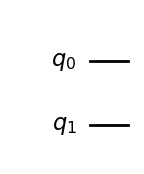

Case 2:


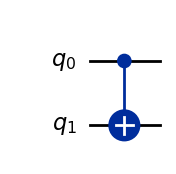

Case 3:


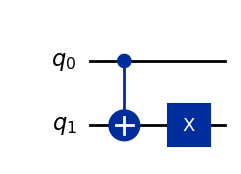

Case 4:


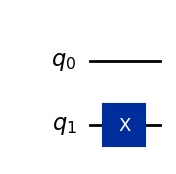

In [5]:
for case in [1, 2, 3, 4]:
    print(f"Case {case}:")
    display(deutsch_function(case).draw(output="mpl"))

### Define the solver circuit

In [6]:
def compile_circuit(function: QuantumCircuit):
    # Compiles a circuit for use in Deutsch's algorithm.
 
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
 
    qc.x(n)
    qc.h(range(n + 1))
 
    qc.barrier()
    qc.compose(function, inplace=True)
    qc.barrier()
 
    qc.h(range(n))
    qc.measure(range(n), range(n))
 
    return qc

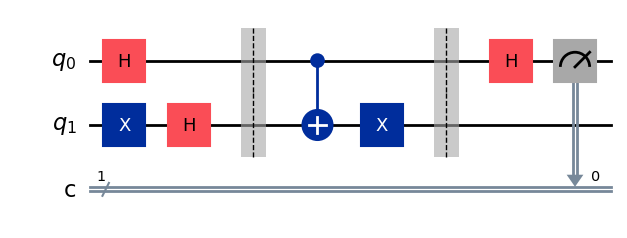

In [7]:
display(compile_circuit(deutsch_function(3)).draw(output="mpl"))

### Define a function to detect function type

In [8]:
def deutsch_algorithm(function: QuantumCircuit):
    # Determine if a one-bit function is constant or balanced.
 
    qc = compile_circuit(function)
 
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if measurements[0] == "0":
        return "constant"
    return "balanced"

In [9]:
f = deutsch_function(3)
display(deutsch_algorithm(f))

'balanced'

### Extra: put on hardware runtime 

In [10]:
case = 3
f = deutsch_function(case)
qc = compile_circuit(f)

In [11]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True)
print("The least busy device is ", backend)

qiskit_runtime_service.__init__:WARNING:2025-11-13 19:24:48,754: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-13 19:24:49,163: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-13 19:24:51,213: Using instance: open-instance, plan: open


The least busy device is  <IBMBackend('ibm_marrakesh')>


In [12]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
qc_compiled = pm.run(qc)

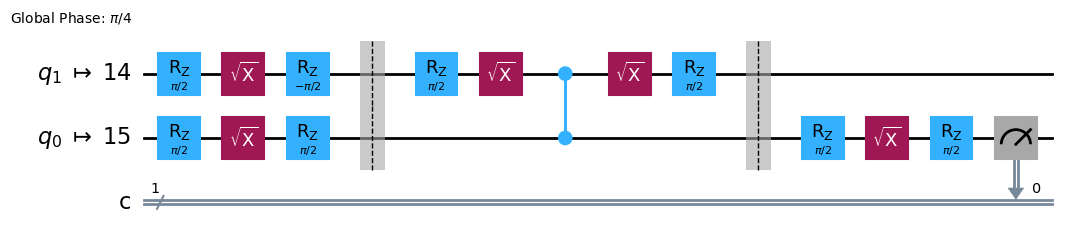

In [13]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
qc_compiled = pm.run(qc)
qc_compiled.draw("mpl", idle_wires=False)

In [14]:
sampler = Sampler(backend)
job = sampler.run([qc_compiled], shots=nshots)
job_id = job.job_id()
print("job id:", job_id)

job id: d4b310q489vs73a31d4g


In [15]:
job = service.job(job_id)  # Input your job-id between the quotations
# job.status()
job_status = 'inited'

while job_status != 'DONE' and job_status != 'CANCELLED' and job_status != 'ERROR':
     job_status = job.status()
     print("job status:", job_status)
     import time
     time.sleep(5)  # wait for 5 seconds before checking again


job status: RUNNING
job status: RUNNING
job status: RUNNING
job status: DONE


In [16]:
real_result = job.result()
counts = real_result[0].data.c.get_counts()
print("Raw counts:", counts)

if counts.get("0", 0) >= counts.get("1", 0):
    print("Hardware says: function is CONSTANT")
else:
    print("Hardware says: function is BALANCED")

Raw counts: {'1': 981, '0': 19}
Hardware says: function is BALANCED


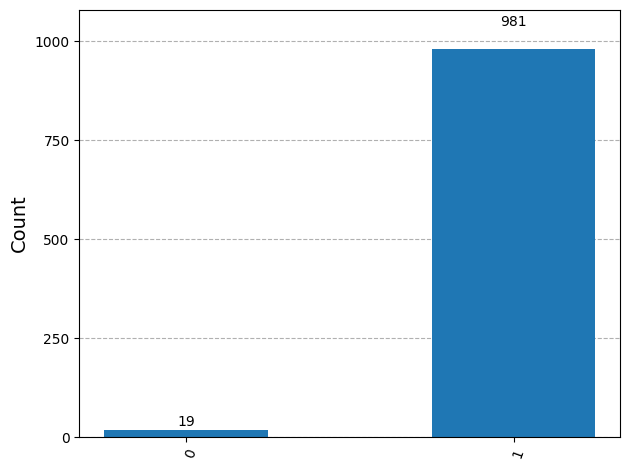

In [17]:
plot_histogram(counts)
